In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from textblob import TextBlob
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [2]:
# datasets
drug_reviews_drugs_com = fetch_ucirepo(id=462)
drug_reviews_druglib_com = fetch_ucirepo(id=461)

# Load the datasets
df1 = drug_reviews_drugs_com.data.features
df2 = drug_reviews_druglib_com.data.features


In [3]:
# Combine datasets
combined_df = pd.concat([df1, df2], ignore_index=True)


In [4]:
## Exploratory Data Analysis (EDA)

In [104]:
print(combined_df.describe())
print(df1['rating'].value_counts())


              rating    usefulCount  benefitsLength  sideEffectsLength  \
count  219206.000000  215063.000000   219206.000000      219206.000000   
mean        6.989184      28.001004        6.870387           6.366254   
std         3.269682      36.346069       38.535313          36.961314   
min         1.000000       0.000000        2.000000           2.000000   
25%         5.000000       6.000000        3.000000           3.000000   
50%         8.000000      16.000000        3.000000           3.000000   
75%        10.000000      36.000000        3.000000           3.000000   
max        10.000000    1291.000000     2296.000000        2551.000000   

       commentsLength  
count   219206.000000  
mean         8.205993  
std         53.693841  
min          1.000000  
25%          3.000000  
50%          3.000000  
75%          3.000000  
max       3859.000000  
rating
10    68005
9     36708
1     28918
8     25046
7     12547
5     10723
2      9265
3      8718
6      8462
4 


Descriptive Statistics:
               rating    usefulCount        cluster  textblob_sentiment  \
count  215063.000000  215063.000000  215063.000000       215063.000000   
mean        6.990008      28.001004       3.061024            0.064654   
std         3.275554      36.346069       1.364479            0.222380   
min         1.000000       0.000000       0.000000           -1.000000   
25%         5.000000       6.000000       2.000000           -0.043750   
50%         8.000000      16.000000       4.000000            0.057566   
75%        10.000000      36.000000       4.000000            0.173391   
max        10.000000    1291.000000       4.000000            1.000000   

           effective  review_length  
count  215063.000000  215063.000000  
mean        0.781920     458.316572  
std         0.412943     240.755597  
min         0.000000       3.000000  
25%         1.000000     262.000000  
50%         1.000000     456.000000  
75%         1.000000     690.000000  
max

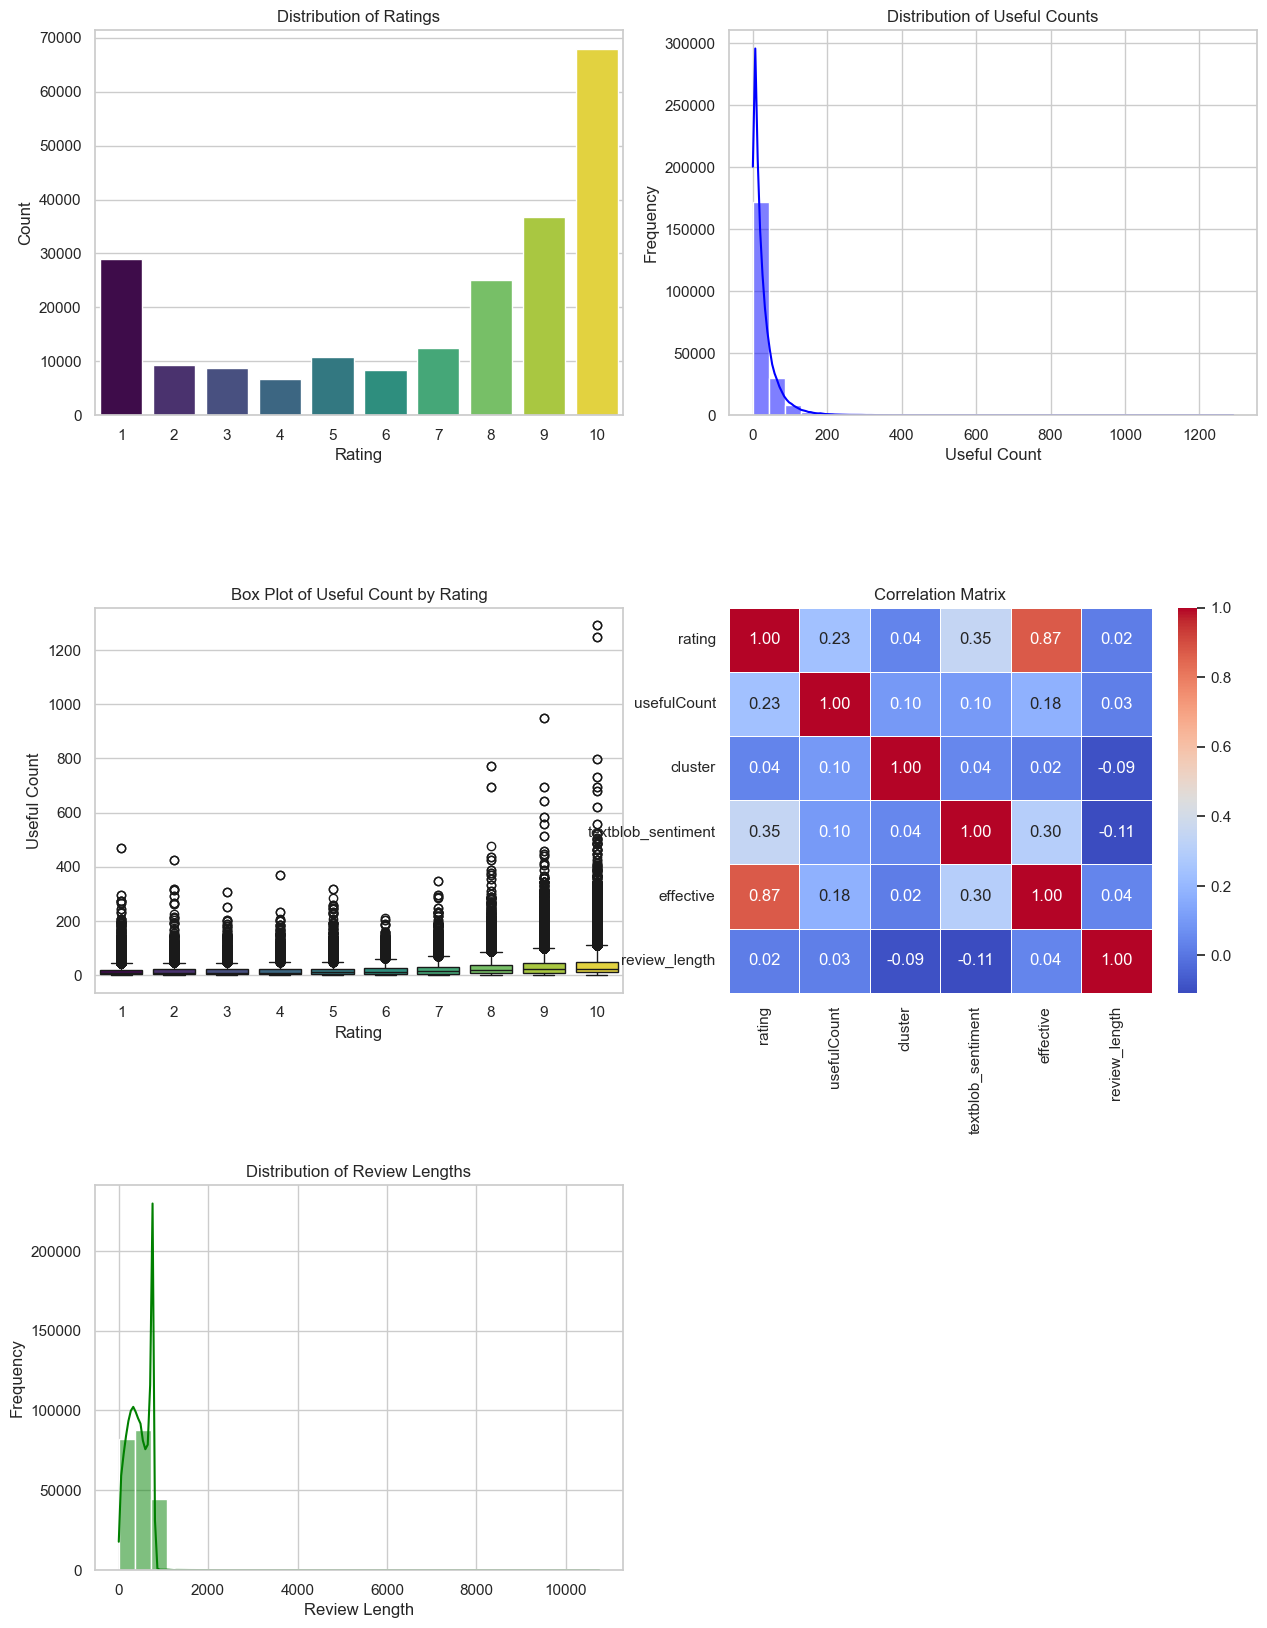

In [96]:
#Descriptive Statistics
print("\nDescriptive Statistics:\n", df1.describe())
print("\nRating Counts:\n", df1['rating'].value_counts())
print("\nCondition Counts (Top 10):\n", df1['condition'].value_counts().head(10))

plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

# Distribution of Ratings
plt.subplot(3, 2, 1)
sns.countplot(data=df1, x='rating', hue='rating', palette='viridis', legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

#  Distribution of Useful Count
plt.subplot(3, 2, 2)
sns.histplot(df1['usefulCount'], bins=30, kde=True, color='blue')
plt.title('Distribution of Useful Counts')
plt.xlabel('Useful Count')
plt.ylabel('Frequency')

# Box Plot for Rating vs. Useful Count
plt.subplot(3, 2, 3)
sns.boxplot(x='rating', y='usefulCount', data=df1, hue='rating', palette='viridis', legend=False)
plt.title('Box Plot of Useful Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')

# Correlation Matrix
plt.subplot(3, 2, 4)
numeric_df1 = df1.select_dtypes(include=[np.number])
correlation_matrix = numeric_df1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

# Review Length Statistics
df1['review_length'] = df1['review'].astype(str).apply(len)
plt.subplot(3, 2, 5)
sns.histplot(df1['review_length'], bins=30, kde=True, color='green')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.show()


Descriptive Statistics by Drug:
                                   drugName     rating                          \
                                                 mean       std min max count   
0                A + D Cracked Skin Relief  10.000000       NaN  10  10     1   
1                               A / B Otic  10.000000  0.000000  10  10     2   
2     Abacavir / dolutegravir / lamivudine   8.414286  2.422676   1  10    70   
3                    Abacavir / lamivudine  10.000000  0.000000  10  10     3   
4       Abacavir / lamivudine / zidovudine   9.000000       NaN   9   9     1   
...                                    ...        ...       ...  ..  ..   ...   
3666                               ZzzQuil   2.000000  1.732051   1   4     3   
3667                 depo-subQ provera 104   5.500000  6.363961   1  10     2   
3668                                  ella   7.183099  3.270255   1  10    71   
3669                                femhrt   6.500000  4.324350   1  10    

/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_34635/1266219649.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='drugName', y='usefulCount', data=df_top_n, estimator=np.mean, errorbar=None, palette='Blues', dodge=True)


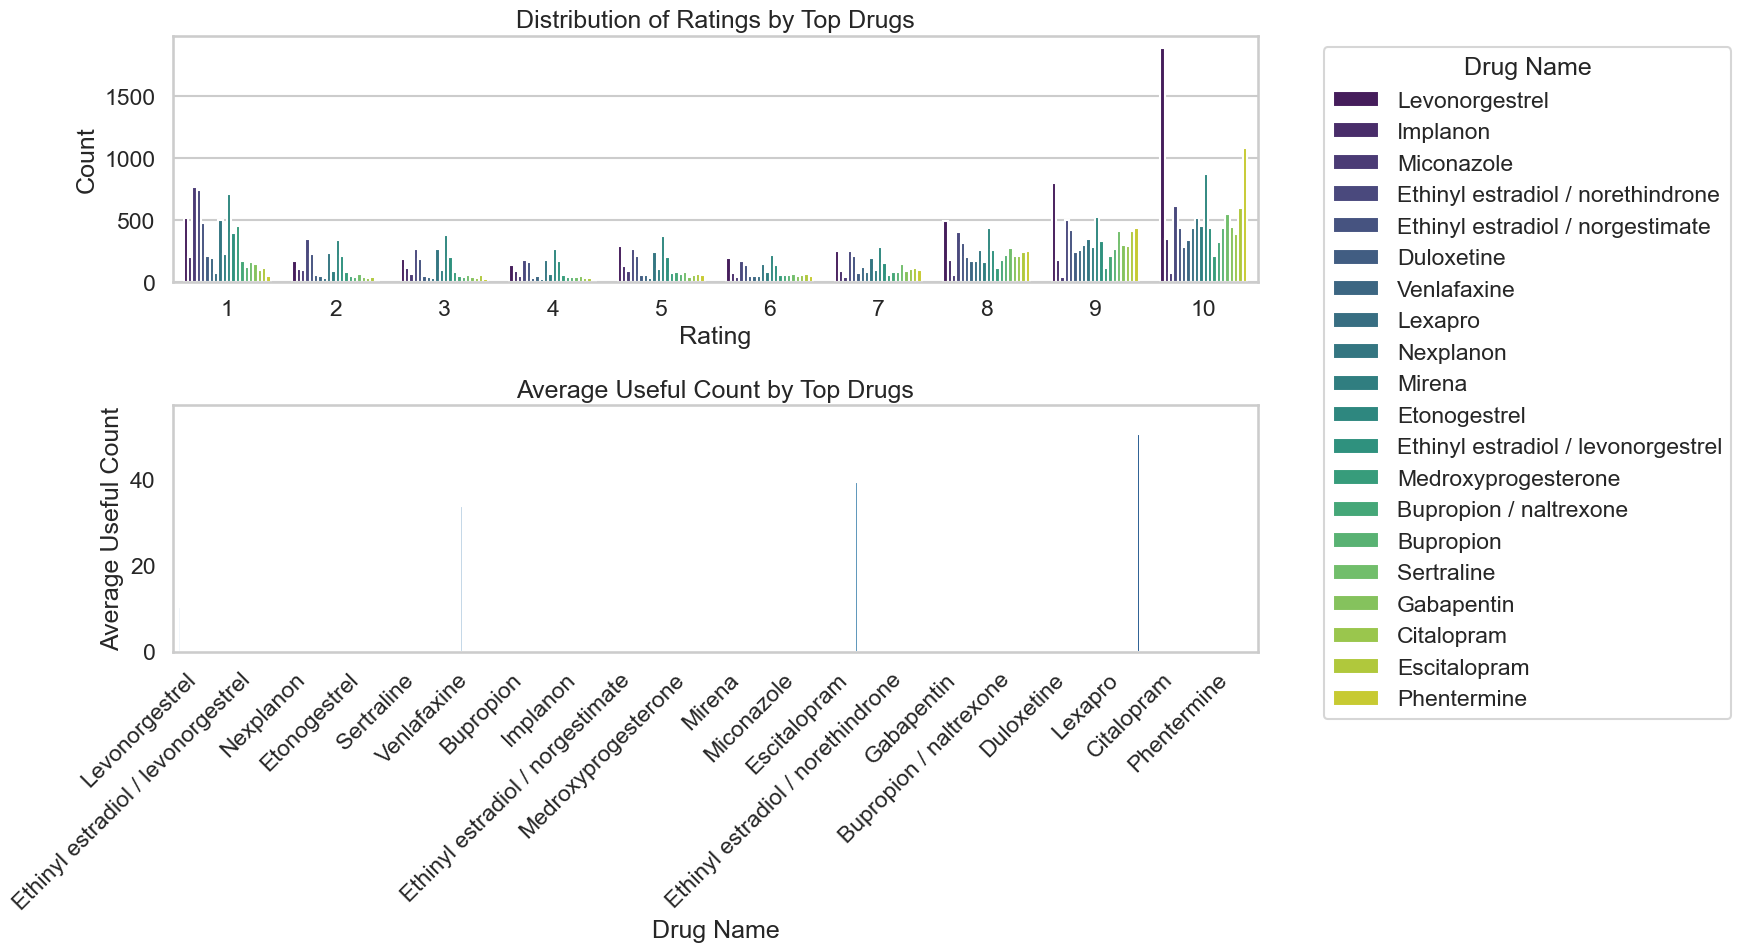

In [188]:
# Descriptive Statistics by Drug
drug_stats = df1.groupby('drugName').agg({
    'rating': ['mean', 'std', 'min', 'max', 'count'],
    'usefulCount': ['mean', 'std', 'min', 'max'],
    'review': 'count'
}).reset_index()

print("\nDescriptive Statistics by Drug:\n", drug_stats)

# Limit to top N drugs based on review count
top_n = drug_stats.nlargest(20, ('rating', 'count'))['drugName']
df_top_n = df1[df1['drugName'].isin(top_n)]


plt.figure(figsize=(14, 8)) 
plt.subplots_adjust(hspace=0.5)

# Distribution of Ratings by Top Drugs
plt.subplot(2, 1, 1)
sns.countplot(data=df_top_n, x='rating', hue='drugName', palette='viridis', dodge=True)
plt.title('Distribution of Ratings by Top Drugs')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Drug Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Average Useful Count by Top Drugs
plt.subplot(2, 1, 2)
sns.barplot(x='drugName', y='usefulCount', data=df_top_n, estimator=np.mean, errorbar=None, palette='Blues', dodge=True)
plt.title('Average Useful Count by Top Drugs')
plt.xlabel('Drug Name')
plt.ylabel('Average Useful Count')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y')

# Show plot
plt.show()

In [169]:
# Convert reviews to string and calculate lengths
#converts review data into string format calculates the length of each review, stores those lengths in new columns
combined_df['benefitsLength'] = combined_df['benefitsReview'].astype(str).apply(len)
combined_df['sideEffectsLength'] = combined_df['sideEffectsReview'].astype(str).apply(len)
combined_df['commentsLength'] = combined_df['commentsReview'].astype(str).apply(len)

# Display descriptive statistics (lengths)
print(combined_df[['benefitsLength', 'sideEffectsLength', 'commentsLength']].describe())


       benefitsLength  sideEffectsLength  commentsLength
count   219206.000000      219206.000000   219206.000000
mean         6.870387           6.366254        8.205993
std         38.535313          36.961314       53.693841
min          2.000000           2.000000        1.000000
25%          3.000000           3.000000        3.000000
50%          3.000000           3.000000        3.000000
75%          3.000000           3.000000        3.000000
max       2296.000000        2551.000000     3859.000000


In [136]:
# Convert 'date' to datetime if not already done, specifying a format if known
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d', errors='coerce')

# Extract year and month for aggregation
df1['year_month'] = df1['date'].dt.to_period('M')

# Average rating per month
monthly_ratings = df1.groupby('year_month')['rating'].mean().reset_index()
monthly_ratings['rating'] = monthly_ratings['rating'].round(2)  # Round ratings for clarity

# Total useful counts per month
monthly_useful_counts = df1.groupby('year_month')['usefulCount'].sum().reset_index()

monthly_summary = pd.merge(monthly_ratings, monthly_useful_counts, on='year_month', suffixes=('_rating', '_usefulCount'))

# Display the result
print(monthly_summary)


    year_month  rating  usefulCount
0      2008-02    7.20        11901
1      2008-03    8.54        56369
2      2008-04    8.97        51389
3      2008-05    9.07        38837
4      2008-06    9.11        42265
..         ...     ...          ...
114    2017-08    5.96        25264
115    2017-09    6.06        18959
116    2017-10    6.02        11851
117    2017-11    5.72         4180
118    2017-12    5.53          301

[119 rows x 3 columns]


Average Ratings Over Time:
    year_month  rating
0      2008-02    7.20
1      2008-03    8.54
2      2008-04    8.97
3      2008-05    9.07
4      2008-06    9.11
..         ...     ...
114    2017-08    5.96
115    2017-09    6.06
116    2017-10    6.02
117    2017-11    5.72
118    2017-12    5.53

[119 rows x 2 columns]

Total Useful Counts Over Time:
    year_month  usefulCount
0      2008-02        11901
1      2008-03        56369
2      2008-04        51389
3      2008-05        38837
4      2008-06        42265
..         ...          ...
114    2017-08        25264
115    2017-09        18959
116    2017-10        11851
117    2017-11         4180
118    2017-12          301

[119 rows x 2 columns]


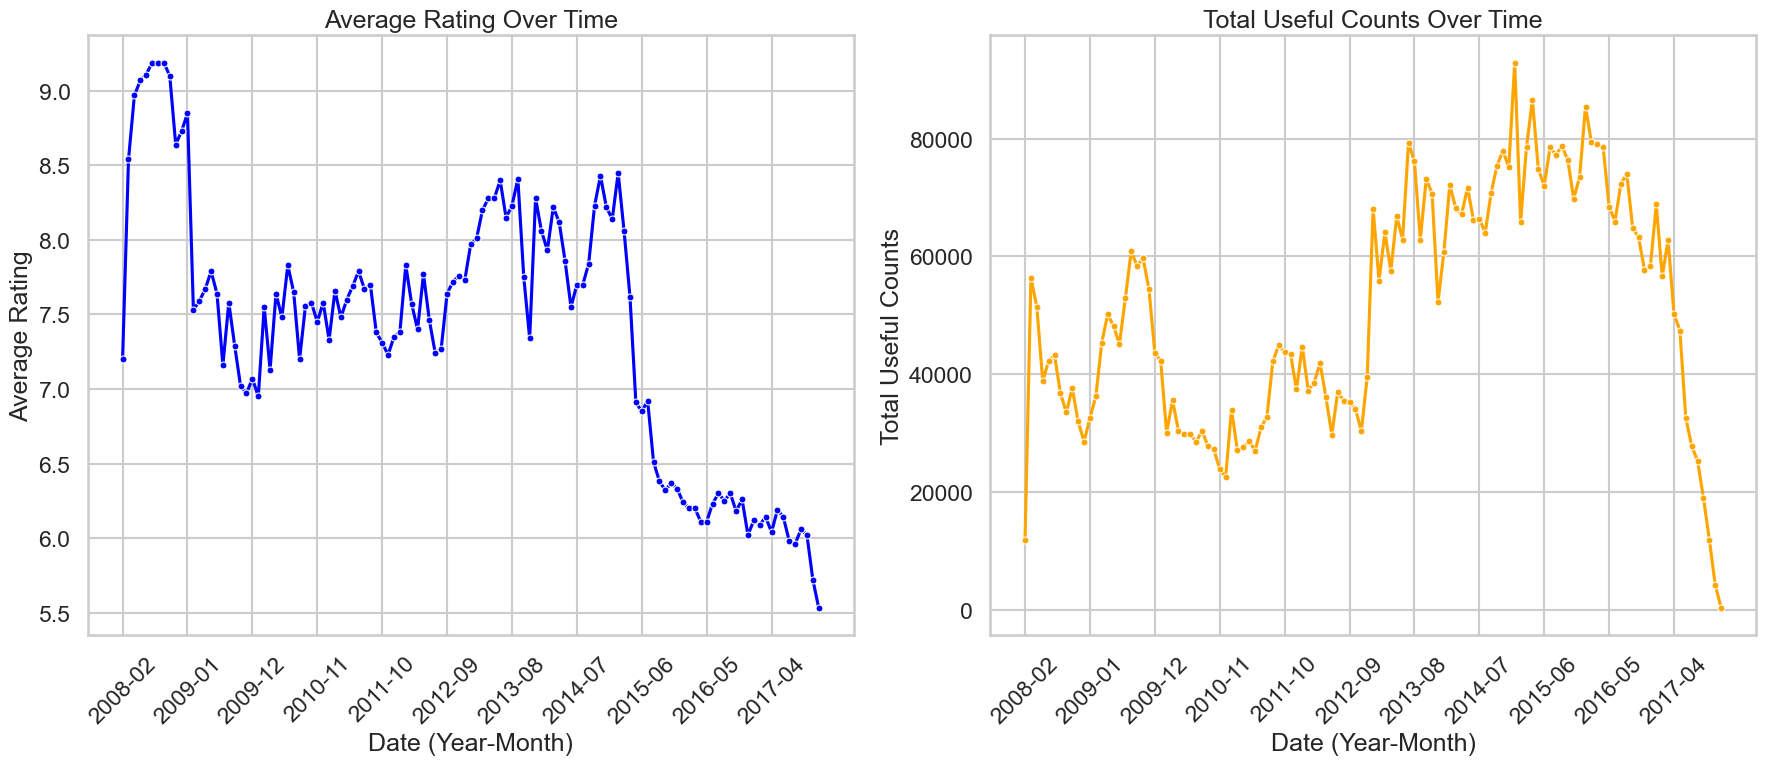

In [156]:
# Convert 'year_month' to string for plotting
monthly_ratings['year_month'] = monthly_ratings['year_month'].astype(str)
monthly_useful_counts['year_month'] = monthly_useful_counts['year_month'].astype(str)

print("Average Ratings Over Time:")
print(monthly_ratings)

print("\nTotal Useful Counts Over Time:")
print(monthly_useful_counts)

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_ratings, x='year_month', y='rating', marker='o', color='blue', markersize=5)
plt.title('Average Rating Over Time')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

# Limit the number of x-ticks
plt.xticks(ticks=range(0, len(monthly_ratings['year_month']), max(1, len(monthly_ratings['year_month']) // 10)), 
           labels=monthly_ratings['year_month'][::max(1, len(monthly_ratings['year_month']) // 10)], rotation=45)

# Plotting Total Useful Counts
plt.subplot(1, 2, 2)
sns.lineplot(data=monthly_useful_counts, x='year_month', y='usefulCount', marker='o', color='orange', markersize=5)
plt.title('Total Useful Counts Over Time')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Total Useful Counts')
plt.xticks(rotation=45)

# Limit the number of x-ticks
plt.xticks(ticks=range(0, len(monthly_useful_counts['year_month']), max(1, len(monthly_useful_counts['year_month']) // 10)), 
           labels=monthly_useful_counts['year_month'][::max(1, len(monthly_useful_counts['year_month']) // 10)], rotation=45)

plt.tight_layout()
plt.show()


Descriptive Statistics for Sentiment:
 count    215063.000000
mean          0.064654
std           0.222380
min          -1.000000
25%          -0.043750
50%           0.057566
75%           0.173391
max           1.000000
Name: sentiment, dtype: float64

Sentiment Distribution:
 sentiment_category
Neutral     93426
Positive    85628
Negative    35468
Name: count, dtype: int64


/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_34635/4237871766.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_counts_df, x='sentiment_category', y='count', hue=None, palette='pastel')


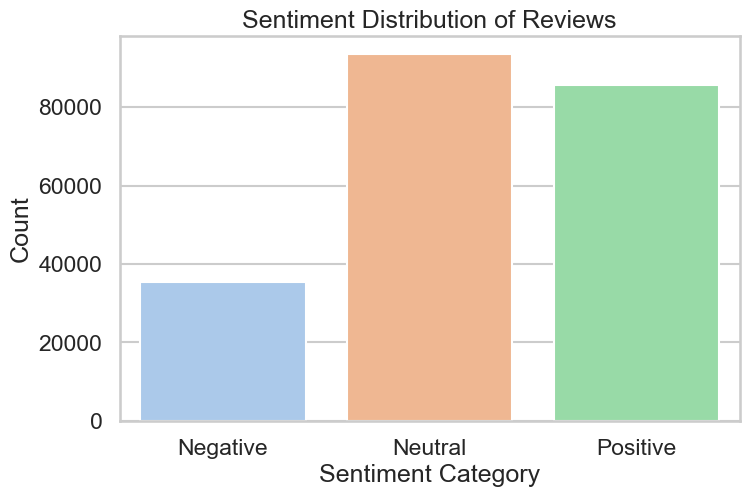

In [158]:
# Function to calculate sentiment
def get_sentiment(review):
    return TextBlob(review).sentiment.polarity  
# Apply sentiment function to reviews
df1['sentiment'] = df1['review'].apply(get_sentiment)

# Descriptive statistics for sentiment
sentiment_desc = df1['sentiment'].describe()
print("\nDescriptive Statistics for Sentiment:\n", sentiment_desc)

# Categorize sentiment
df1['sentiment_category'] = pd.cut(df1['sentiment'], bins=[-1, -0.1, 0.1, 1], 
                                    labels=['Negative', 'Neutral', 'Positive'])

# Sentiment distribution
sentiment_counts = df1['sentiment_category'].value_counts()
print("\nSentiment Distribution:\n", sentiment_counts)

# Create a DataFrame for sentiment counts
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['sentiment_category', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_counts_df, x='sentiment_category', y='count', hue=None, palette='pastel')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_34635/2744593534.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='effectiveness', palette='plasma')


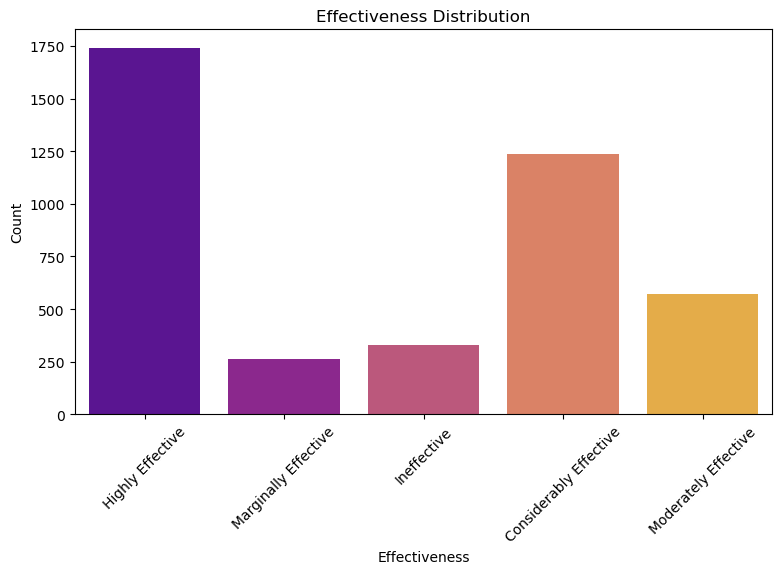

In [18]:
plt.figure(figsize=(9, 5))
sns.countplot(data=combined_df, x='effectiveness', palette='plasma')
plt.title('Effectiveness Distribution')
plt.xlabel('Effectiveness')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


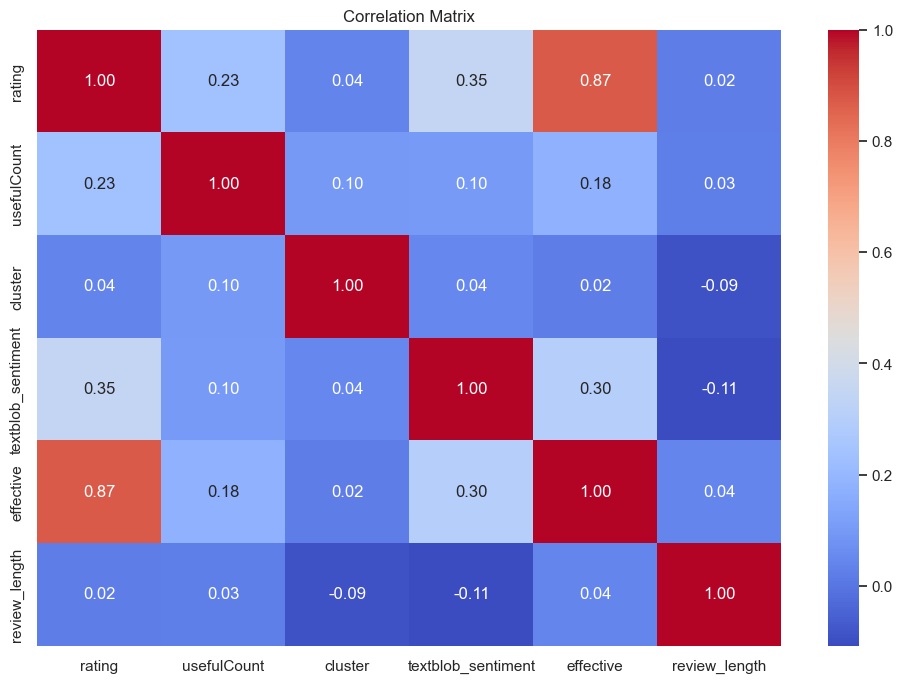

In [108]:
# Select only numeric columns for correlation calculation
numeric_df = df1.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


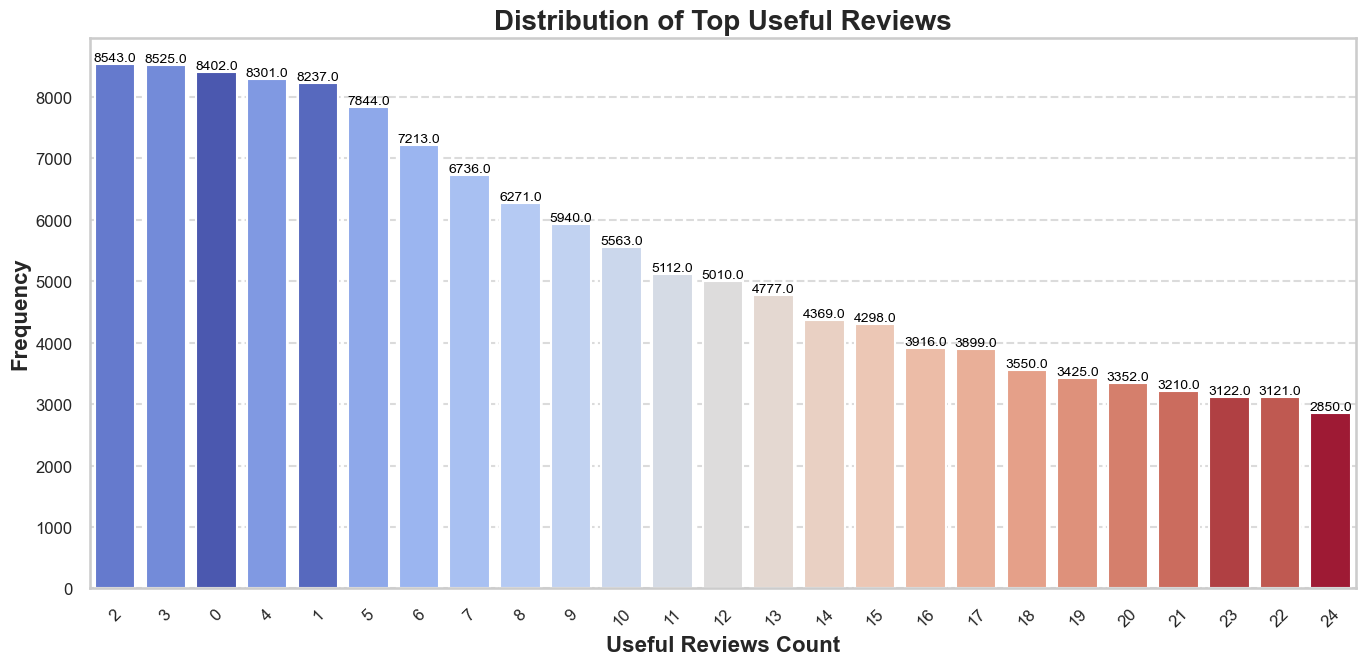

In [130]:
# Set the style and context of the plot
sns.set(style="whitegrid", context="talk")

# Determine the top N useful review counts
top_n = 25 
top_useful_counts = df1['usefulCount'].value_counts().nlargest(top_n)

plt.figure(figsize=(14, 7))

# Filter df1 based on its own usefulCount column
filtered_data = df1[df1['usefulCount'].isin(top_useful_counts.index)]

# Create the count plot without palette warning
sns.countplot(data=filtered_data,
              x='usefulCount', 
              order=top_useful_counts.index,
              hue='usefulCount',  # Assigning hue for color differentiation
              palette='coolwarm', 
              legend=False)  # Disable legend if not needed

# Add titles and labels with increased font sizes
plt.title('Distribution of Top Useful Reviews', fontsize=20, weight='bold')
plt.xlabel('Useful Reviews Count', fontsize=16, weight='bold')
plt.ylabel('Frequency', fontsize=16, weight='bold')

# Enhance x-tick labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with their counts
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., 
                  p.get_height()), 
                 ha='center', va='bottom', 
                 fontsize=10, color='black')

plt.tight_layout() 
plt.show()


In [4]:
def rename_columns(df):
    df = df.rename(columns={
        'urlDrugName': 'drug_name',
        'sideEffects': 'side_effects',
        'benefitsReview': 'benefits_review',
        'sideEffectsReview': 'side_effects_review',
        'commentsReview': 'comments_review'  # Include comments column
    })
    return df

# Rename columns in both DataFrames
df1 = rename_columns(df1)
df2 = rename_columns(df2)

# Check the column names after renaming
print("Columns in Dataset 1:", df1.columns)
print("Columns in Dataset 2:", df2.columns)

# Combine specified columns into a single 'reviews' column
df2['reviews'] = df2[['benefits_review', 'side_effects_review', 'comments_review']].apply(
    lambda x: ' '.join(x.dropna()), axis=1
)


Columns in Dataset 1: Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')
Columns in Dataset 2: Index(['drug_name', 'rating', 'effectiveness', 'side_effects', 'condition',
       'benefits_review', 'side_effects_review', 'comments_review'],
      dtype='object')


'drug_name' column not found in Dataset 1.


<Figure size 1200x600 with 0 Axes>

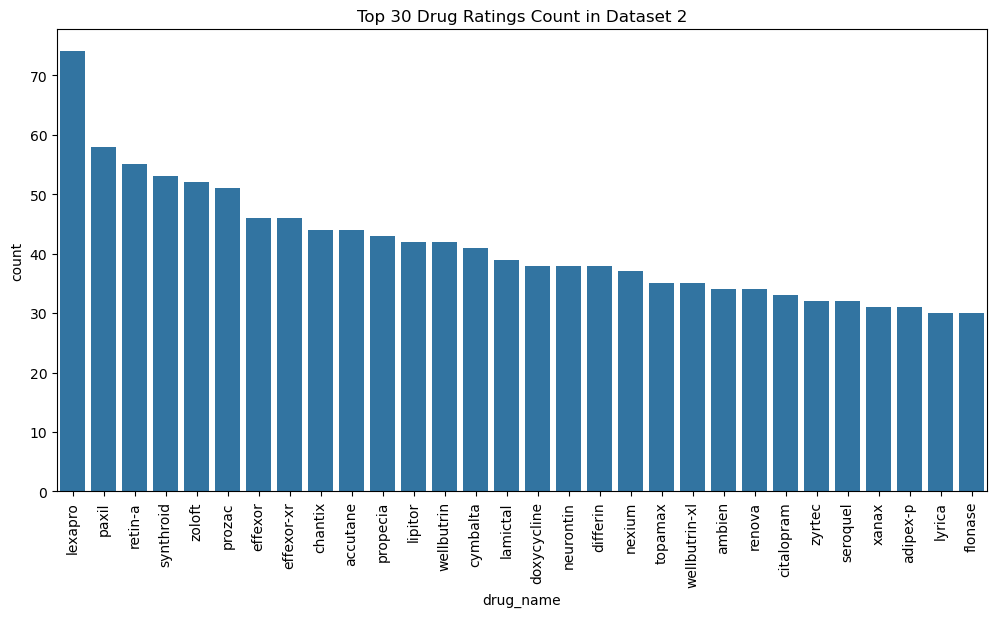

In [7]:
def plot_drug_ratings(df, dataset_name, top_n=30):
    plt.figure(figsize=(12, 6))
    
    # Check if drug_name exists 
    if 'drug_name' in df.columns:
        # Get the top N drugs based on count
        top_drugs = df['drug_name'].value_counts().nlargest(top_n).index
        sns.countplot(data=df[df['drug_name'].isin(top_drugs)], x='drug_name', order=top_drugs)
        plt.title(f'Top {top_n} Drug Ratings Count in {dataset_name}')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"'drug_name' column not found in {dataset_name}.")

# Plot for both datasets
plot_drug_ratings(df1, "Dataset 1", top_n=30)
plot_drug_ratings(df2, "Dataset 2", top_n=30)


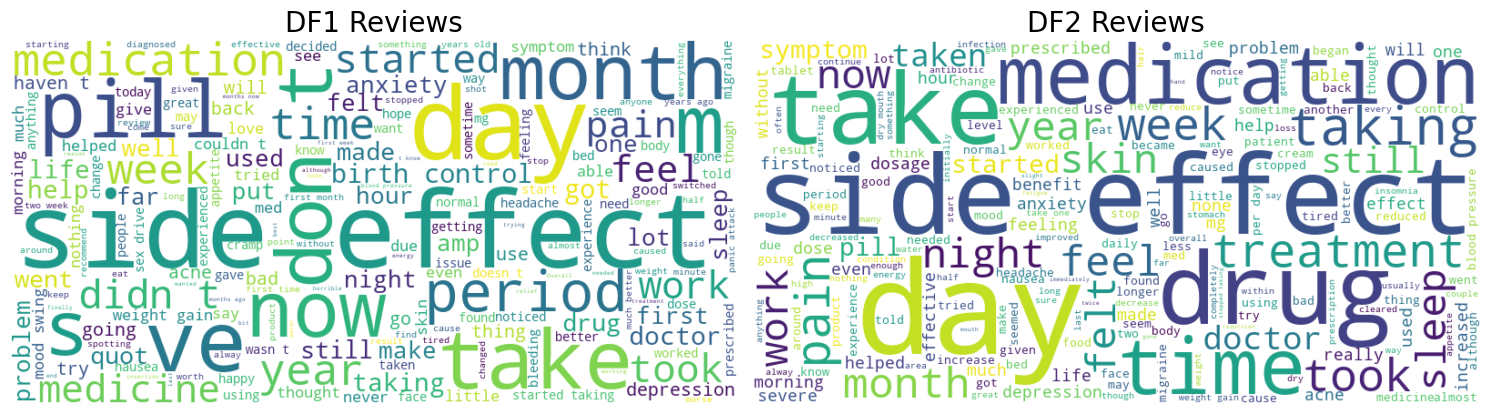

In [29]:
df1_reviews = ' '.join(df1['review'].dropna().astype(str))
wordcloud_df1 = WordCloud(width=800, height=400, background_color='white').generate(df1_reviews)

# Generate word cloud for df2
df2_reviews = ' '.join(df2['reviews'].dropna().astype(str))
wordcloud_df2 = WordCloud(width=800, height=400, background_color='white').generate(df2_reviews)

# Set up the plot for both word clouds
plt.figure(figsize=(15, 10))

# Plot for df1
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_df1, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("DF1 Reviews", fontsize=20)

# Plot for df2
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_df2, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("DF2 Reviews", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()

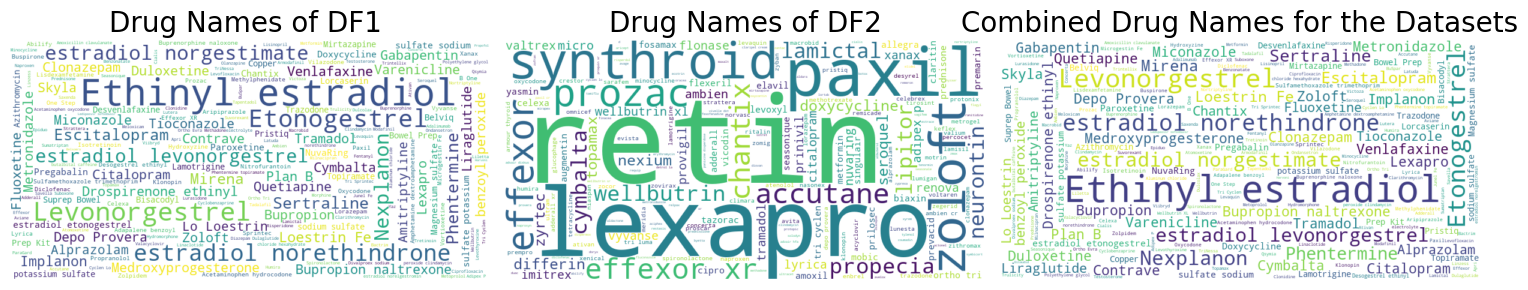

In [30]:
# Generate word cloud for df1 drug names
df1_drug_names = ' '.join(df1['drugName'].dropna().astype(str))
wordcloud_df1 = WordCloud(width=800, height=400, background_color='white').generate(df1_drug_names)

# Generate word cloud for df2 drug names
df2_drug_names = ' '.join(df2['drug_name'].dropna().astype(str))
wordcloud_df2 = WordCloud(width=800, height=400, background_color='white').generate(df2_drug_names)

# Combine drug names for both datasets
combined_drug_names = df1_drug_names + ' ' + df2_drug_names
wordcloud_combined = WordCloud(width=800, height=400, background_color='white').generate(combined_drug_names)

# Set up the plot for all three word clouds
plt.figure(figsize=(15, 10))

# Plot for df1
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_df1, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Drug Names of DF1 ", fontsize=20)

# Plot for df2
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_df2, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Drug Names of DF2", fontsize=20)

# Plot for combined drug names
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Combined Drug Names for the Datasets", fontsize=20)

# Show the plots
plt.tight_layout()
plt.show()


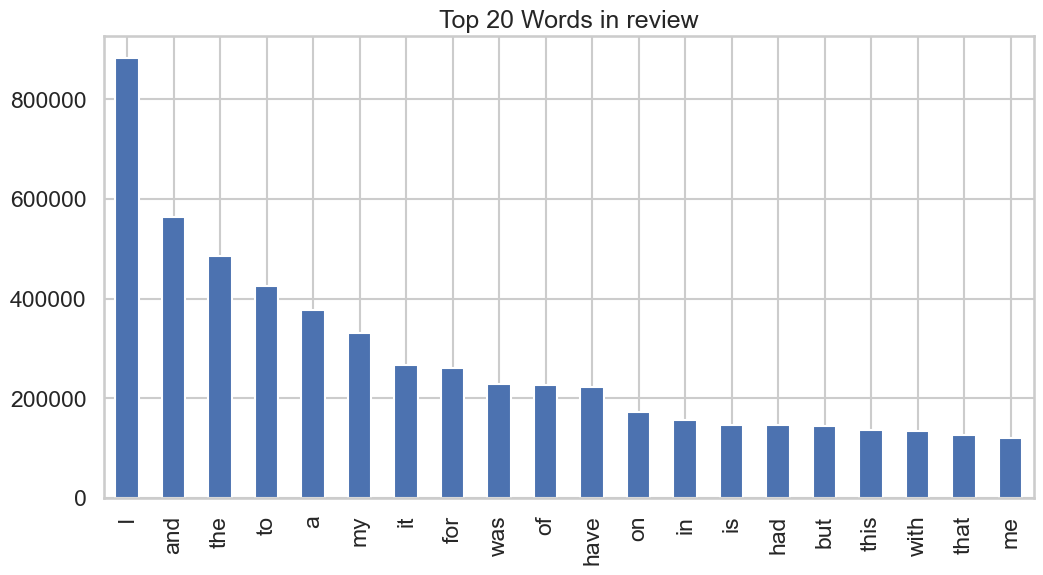

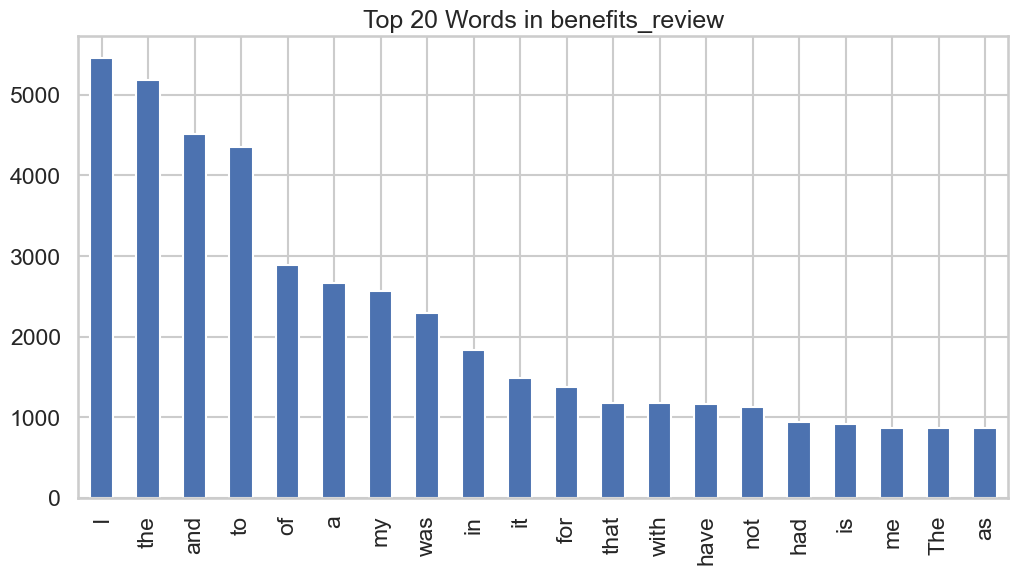

In [132]:
def plot_word_frequency(df, column_name):
    if column_name in df.columns:
        all_reviews = ' '.join(df[column_name].dropna())
        words = all_reviews.split()
        word_freq = pd.Series(words).value_counts().head(20)  
        word_freq.plot(kind='bar', figsize=(12, 6))
        plt.title(f'Top 20 Words in {column_name}')
        plt.show()
    else:
        print(f"'{column_name}' column not found in the DataFrame.")

# Plot for benefits reviews
plot_word_frequency(df1, 'review')
plot_word_frequency(df2, 'benefits_review')


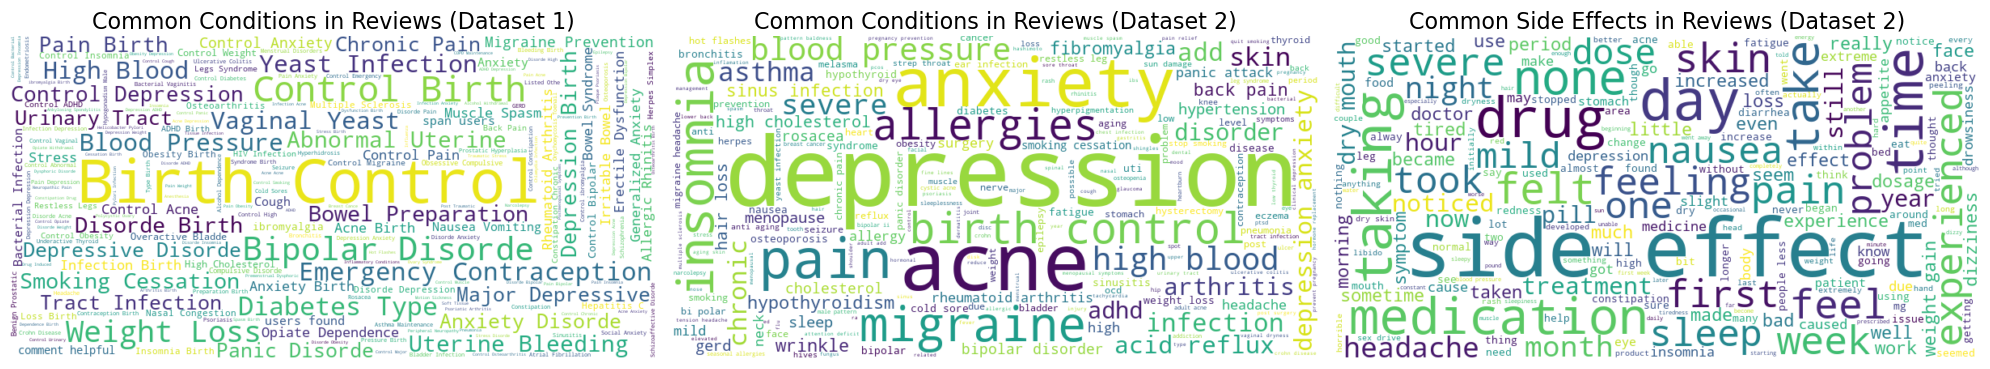

In [32]:
# Generate word cloud for conditions in df1
condition_text_df1 = ' '.join(df1['condition'].dropna())
wordcloud_conditions_df1 = WordCloud(width=800, height=400, background_color='white').generate(condition_text_df1)

# Generate word cloud for conditions in df2
condition_text_df2 = ' '.join(df2['condition'].dropna())
wordcloud_conditions_df2 = WordCloud(width=800, height=400, background_color='white').generate(condition_text_df2)

# Generate word cloud for side effects in df2
side_effects_text = ' '.join(df2['side_effects_review'].dropna())
wordcloud_side_effects = WordCloud(width=800, height=400, background_color='white').generate(side_effects_text)

# Set up the plot for all three word clouds
plt.figure(figsize=(20, 7))

# Plot for conditions in df1
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_conditions_df1, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 1)', fontsize=16)

# Plot for conditions in df2
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_conditions_df2, interpolation='bilinear')
plt.axis('off')
plt.title('Common Conditions in Reviews (Dataset 2)', fontsize=16)

# Plot for side effects in df2
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_side_effects, interpolation='bilinear')
plt.axis('off')
plt.title('Common Side Effects in Reviews (Dataset 2)', fontsize=16)

# Show the plots
plt.tight_layout()
plt.show()



In [5]:
# (remove punctuation, lowercase, remove numbers)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  
        text = re.sub(r'[^\w\s]', '', text)  
    return text

# Apply the cleaning function to the review column
df1['cleaned_review'] = df1['review'].apply(clean_text)


In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text 
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  
        text = re.sub(r'[^\w\s]', '', text)
    return text

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words
    return []  # Return an empty list if text is not a string

# Clean the review column
df1['cleaned_review'] = df1['review'].apply(clean_text)

# Apply tokenization and stopword removal
df1['tokens_review'] = df1['cleaned_review'].apply(tokenize_and_remove_stopwords)

# tokenized data
#print("Tokenized review:", df1['tokens_review'].head())


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize words
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization
df1['lemmatized_review'] = df1['tokens_review'].apply(lemmatize_words)

# lemmatized data
#print("Lemmatized review:", df1['lemmatized_review'].head(5))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/katerineosorio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:
    # Use the entire dataset for TF-IDF
    text_column = df1['lemmatized_review'].astype(str)
    
    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    X_tfidf = tfidf_vectorizer.fit_transform(text_column)

    # Display the shape of the TF-IDF matrix
    print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (215063, 500)


TF-IDF matrix shape: (215063, 500)
Top TF-IDF terms:
 day       0.054130
month     0.042913
year      0.042557
pain      0.039958
effect    0.039835
week      0.038042
im        0.036984
taking    0.036665
mg        0.035442
work      0.034980
dtype: float64


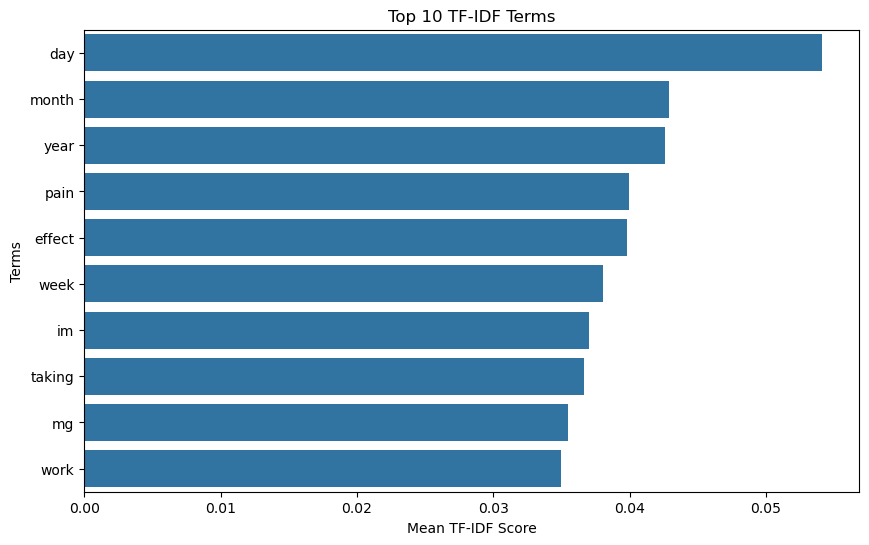

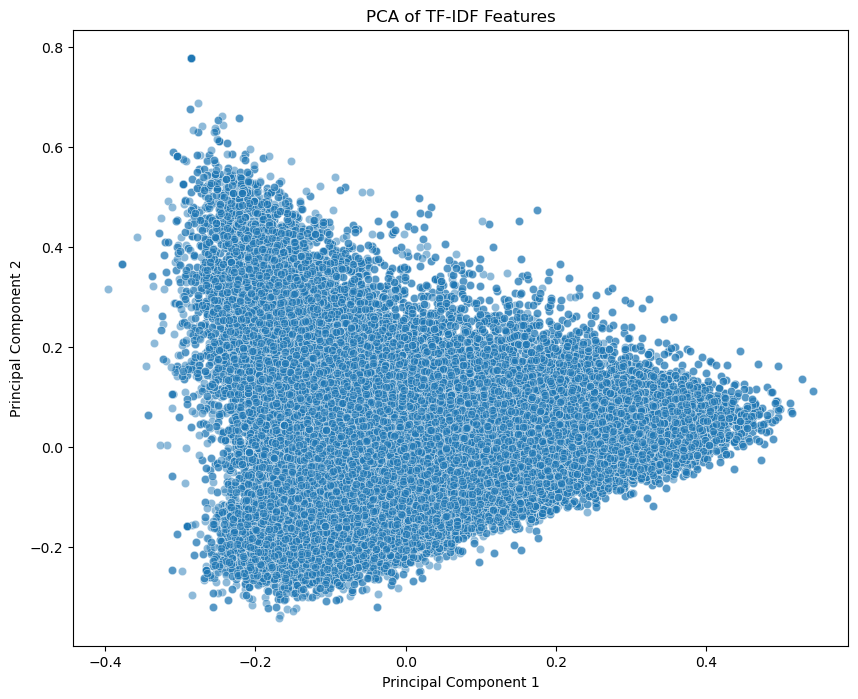

In [20]:
from sklearn.decomposition import PCA

# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:
    # Use the entire dataset for TF-IDF
    text_column = df1['lemmatized_review'].astype(str)
    
    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    X_tfidf = tfidf_vectorizer.fit_transform(text_column)

    # Display the shape of the TF-IDF matrix
    print("TF-IDF matrix shape:", X_tfidf.shape)

    # Convert to DataFrame for easier analysis
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
    # Display top terms by their mean TF-IDF score
    mean_tfidf_scores = tfidf_df.mean().sort_values(ascending=False)
    print("Top TF-IDF terms:\n", mean_tfidf_scores.head(10))

    # Visualize the top TF-IDF terms
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mean_tfidf_scores.head(10).values, y=mean_tfidf_scores.head(10).index)
    plt.title('Top 10 TF-IDF Terms')
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Terms')
    plt.show()

    # Dimensionality reduction using PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_tfidf.toarray())

    # Create a DataFrame for the PCA result
    pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

    # Visualize PCA results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.5)
    plt.title('PCA of TF-IDF Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


In [10]:

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Ensure that you have a column with the raw reviews, for example, 'review'
if 'review' in df1.columns:
    # Apply sentiment analysis to the raw review column
    df1['comments_review_sentiment'] = df1['review'].apply(analyze_sentiment)

    # Extract compound sentiment score
    df1['comments_sentiment_score'] = df1['comments_review_sentiment'].apply(lambda x: x['compound'])

    # Check the distribution of sentiment scores
    print("Sentiment score distribution:")
    print(df1['comments_sentiment_score'].describe())

    # Print sentiment scores for the top n rows
    print("Sentiment scores for comments reviews:")
    print(df1[['review', 'comments_sentiment_score']].head(10))

    # Identify reviews with significant sentiment scores
    significant_sentiment = df1[df1['comments_sentiment_score'].abs() > 0.1]  # Adjust the threshold as needed
    print("Reviews with significant sentiment scores:")
    print(significant_sentiment[['review', 'comments_sentiment_score']].head(5))


Sentiment score distribution:
count    215063.000000
mean         -0.042509
std           0.680252
min          -0.998400
25%          -0.726900
50%          -0.050700
75%           0.636900
max           0.995200
Name: comments_sentiment_score, dtype: float64
Sentiment scores for comments reviews:
                                              review  comments_sentiment_score
0  "It has no side effect, I take it in combinati...                   -0.2960
1  "My son is halfway through his fourth week of ...                    0.8603
2  "I used to take another oral contraceptive, wh...                    0.7962
3  "This is my first time using any form of birth...                    0.7184
4  "Suboxone has completely turned my life around...                    0.9403
5  "2nd day on 5mg started to work with rock hard...                   -0.4342
6  "He pulled out, but he cummed a bit in me. I t...                    0.0000
7  "Abilify changed my life. There is hope. I was...                

In [11]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def analyze_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)
    else:
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply sentiment analysis to the entire DataFrame
df1['comments_review_sentiment'] = df1['lemmatized_review'].apply(analyze_sentiment)

# Extract compound sentiment score
df1['comments_sentiment_score'] = df1['comments_review_sentiment'].apply(lambda x: x['compound'])

# Check the distribution of sentiment scores
print("Sentiment score distribution:")
print(df1['comments_sentiment_score'].describe())

# Print sentiment scores for the top 30 rows
print("Sentiment scores for comments reviews:")
print(df1[['lemmatized_review', 'comments_sentiment_score']].head(15))

# Identify reviews with significant sentiment scores
significant_sentiment = df1[df1['comments_sentiment_score'].abs() > 0.1]  # Adjust the threshold as needed
print("Reviews with significant sentiment scores:")
print(significant_sentiment[['lemmatized_review', 'comments_sentiment_score']].head(5))



Sentiment score distribution:
count    215063.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: comments_sentiment_score, dtype: float64
Sentiment scores for comments reviews:
                                    lemmatized_review  \
0   [side, effect, take, combination, bystolic, mg...   
1   [son, halfway, fourth, week, intuniv, became, ...   
2   [used, take, another, oral, contraceptive, pil...   
3   [first, time, using, form, birth, control, im,...   
4   [suboxone, completely, turned, life, around, f...   
5   [nd, day, mg, started, work, rock, hard, erect...   
6   [pulled, cummed, bit, took, plan, b, hour, lat...   
7   [abilify, changed, life, hope, zoloft, clonidi...   
8   [nothing, problem, keppera, constant, shaking,...   
9   [pill, many, year, doctor, changed, rx, chatea...   
10  [medication, almost, two, week, started, mg, w...   
11  [taken, antidepressant, year, improvement, mos...   

In [26]:
from sklearn.cluster import KMeans

 # Use TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df1['review'].astype(str))

# Apply K-means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df1['cluster'] = kmeans.fit_predict(X_tfidf)

# Print cluster assignments
print("Cluster assignments for reviews:")
print(df1[['review', 'cluster']].head(5))


Cluster assignments for reviews:
                                              review  cluster
0  "It has no side effect, I take it in combinati...        1
1  "My son is halfway through his fourth week of ...        1
2  "I used to take another oral contraceptive, wh...        4
3  "This is my first time using any form of birth...        4
4  "Suboxone has completely turned my life around...        1


In [30]:
# Use TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

# Apply K-means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df1['cluster'] = kmeans.fit_predict(X_tfidf)

# Print cluster assignments
print("Cluster assignments for lemmatized reviews:")
print(df1[['lemmatized_review', 'cluster']].head(5))

Cluster assignments for lemmatized reviews:
                                   lemmatized_review  cluster
0  [side, effect, take, combination, bystolic, mg...        4
1  [son, halfway, fourth, week, intuniv, became, ...        4
2  [used, take, another, oral, contraceptive, pil...        2
3  [first, time, using, form, birth, control, im,...        2
4  [suboxone, completely, turned, life, around, f...        4


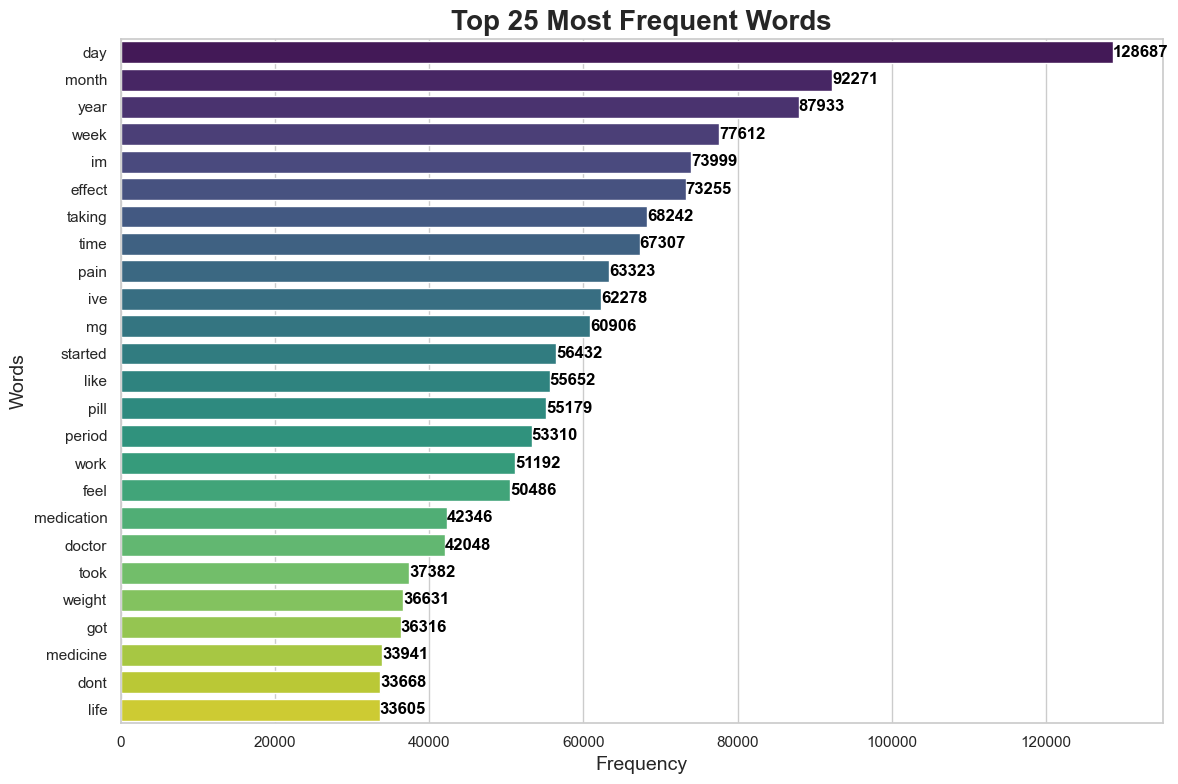

In [17]:
# Function to plot most frequent words
def plot_most_frequent_words(text_column, top_n=20):
    # Use CountVectorizer to get word frequencies
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_matrix = vectorizer.fit_transform(text_column)
    word_freq = np.asarray(word_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()

    # Create a DataFrame for plotting
    word_freq_dict = dict(zip(words, word_freq))
    sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])

    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.set_theme(style='whitegrid', palette='pastel')

    # Create a horizontal bar plot with hue
    bar_plot = sns.barplot(x='Frequency', y='Word', data=word_df, hue='Word', palette='viridis', legend=False)
    plt.title(f'Top {top_n} Most Frequent Words', fontsize=20, weight='bold')
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)

    # Add value annotations on the bars with more styling
    for index, value in enumerate(word_df['Frequency']):
        bar_plot.text(value, index, f'{value}', color='black', ha='left', va='center', fontsize=12, weight='bold')

    # Enhance layout with tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Check for the lemmatized review column
if 'lemmatized_review' in df1.columns:  
    # Plot the most frequent words in the entire dataset
    plot_most_frequent_words(df1['lemmatized_review'].astype(str), top_n=25)

In [18]:
# Check if necessary columns exist
if 'lemmatized_review' in df1.columns:  
    # Optionally limit the size of the dataset for faster processing
    max_rows = 100000  # Adjust this as needed
    text_column = df1['lemmatized_review'].astype(str).head(max_rows)  # Use only the top 'max_rows'

    # Use CountVectorizer for LDA with a limit on the number of features
    vectorizer = CountVectorizer(stop_words='english', max_features=200)  # Reduce max_features further
    X = vectorizer.fit_transform(text_column)

    # Apply LDA for topic modeling with fewer topics
    lda = LatentDirichletAllocation(n_components=3, random_state=42, n_jobs=-1)  # Use all available cores
    lda.fit(X)

    # Function to display top words in each topic
    def print_lda_topics(lda, vectorizer, top_n=10):
        words = vectorizer.get_feature_names_out()
        for i, topic in enumerate(lda.components_):
            print(f"Topic {i + 1}:")
            print([words[i] for i in topic.argsort()[-top_n:]])

    # Print the top words for each topic
    print_lda_topics(lda, vectorizer)



Topic 1:
['weight', 'year', 'day', 'week', 'control', 'im', 'ive', 'pill', 'period', 'month']
Topic 2:
['life', 'doctor', 'time', 'medicine', 'medication', 'effect', 'day', 'work', 'year', 'pain']
Topic 3:
['anxiety', 'like', 'effect', 'started', 'im', 'taking', 'feel', 'week', 'mg', 'day']


In [19]:
def analyze_sentiment_textblob(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    return 0

# Apply TextBlob sentiment analysis
df1['textblob_sentiment'] = df1['review'].apply(analyze_sentiment_textblob)
print("TextBlob sentiment score distribution:")
print(df1['textblob_sentiment'].describe())


TextBlob sentiment score distribution:
count    215063.000000
mean          0.064654
std           0.222380
min          -1.000000
25%          -0.043750
50%           0.057566
75%           0.173391
max           1.000000
Name: textblob_sentiment, dtype: float64


# Based on the rating the review received. If the rating is above 3 (out of 5), the review is labeled as effective (1); otherwise, it’s labeled as not effective (0).

In [8]:
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack

# Step 1: Convert 'rating' to a binary target variable
df1['effective'] = (df1['rating'] > 3).astype(int)

# Step 2: Prepare text features (lemmatized reviews) and numerical features (usefulCount)
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['usefulCount']]

# Step 3: Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Combine TF-IDF features with numerical features
X_features = hstack([X_tfidf, X_numerical])

# Step 4: Prepare the target variable
y = df1['effective']

# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Step 6: Scale numerical features and train logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increase iterations

# Create a pipeline for scaling and fitting the model
pipeline = make_pipeline(StandardScaler(with_mean=False), log_reg)  # with_mean=False for sparse matrix
pipeline.fit(X_train, y_train)

# Step 7: Predictions
y_pred = pipeline.predict(X_test)

# Step 8: Classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.56      0.63      9423
           1       0.88      0.94      0.91     33590

    accuracy                           0.85     43013
   macro avg       0.80      0.75      0.77     43013
weighted avg       0.85      0.85      0.85     43013



In [9]:
# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  
    ('log_reg', LogisticRegression(solver='liblinear', max_iter=1500))
])

# Define an expanded hyperparameter grid
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10], 
    'log_reg__max_iter': [10, 50, 100], 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,       # Number of folds
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores for parallel processing
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate metrics on the best model
y_pred = grid_search.best_estimator_.predict(X_test)  
print(classification_report(y_test, y_pred)) 


Best parameters: {'log_reg__C': 0.01, 'log_reg__max_iter': 10}
Best cross-validation score: 0.8550247021214764
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      9423
           1       0.88      0.94      0.91     33590

    accuracy                           0.85     43013
   macro avg       0.80      0.75      0.77     43013
weighted avg       0.85      0.85      0.85     43013



In [ ]:
### BEWARE, WILL TAKE A LONG TIME TO LOAD

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

# Step 1: Feature Engineering
df1['lemmatized_review'] = df1['lemmatized_review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df1['review_length'] = df1['lemmatized_review'].apply(len)
df1['sentiment'] = df1['lemmatized_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df1['subjectivity'] = df1['lemmatized_review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df1['rating_sentiment_interaction'] = df1['rating'] * df1['sentiment']

# Prepare the features
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['rating', 'review_length', 'sentiment', 'subjectivity', 'rating_sentiment_interaction']]

# Step 2: Vectorize the text data using TF-IDF (with fewer features)
tfidf_vectorizer = TfidfVectorizer(max_features=300, ngram_range=(1, 1), stop_words='english')  # Use fewer features
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Combine TF-IDF with numerical features
X_features = hstack([X_tfidf, X_numerical])

# Target variable
y = df1['usefulCount']

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Step 4: Model and GridSearchCV with hyperparameter grid
model = make_pipeline(StandardScaler(with_mean=False), RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))

# Simplified hyperparameter grid
param_grid = {
    'randomforestregressor__n_estimators': [50, 100],  
    'randomforestregressor__max_depth': [10, None],  
    'randomforestregressor__min_samples_split': [2, 5]  
}

# Step 5: Create GridSearchCV object
grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=3,  # Use 3-fold cross-validation for better model evaluation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores for parallel computation
    verbose=1  # Show progress
)

# Step 6: Fit the model
grid_search.fit(X_train, y_train)

# Step 7: Best hyperparameters and evaluation
print(f"Best hyperparameters: {grid_search.best_params_}")
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Step 8: Cross-validation to check model's generalization
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_features, y, cv=3, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cross_val_scores.mean()}")



Fitting 3 folds for each of 8 candidates, totalling 24 fits


#  model that predicts if a review is "useful" or "not useful" based on:

# The content of the review.
# The rating (how good the review is, based on the reviewer’s score).

In [10]:
# Convert 'usefulCount' to a binary target variable
df1['useful_binary'] = (df1['usefulCount'] > 5).astype(int)

# Prepare features and target
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['rating']]
X_tfidf = TfidfVectorizer(max_features=2000).fit_transform(X_text)
X_features = hstack([X_tfidf, X_numerical])

# Target variable: 'useful_binary'
y = df1['useful_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Create and train a logistic regression model
model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.36      0.46      9815
           1       0.83      0.94      0.88     33198

    accuracy                           0.81     43013
   macro avg       0.73      0.65      0.67     43013
weighted avg       0.79      0.81      0.79     43013



# This model predicts which drug a review is about, based on:

# The content of the review (what the review says about the drug).
# The rating given by the reviewer.


In [ ]:
# 'drugName' (categorical)
y = df1['drugName']

# Prepare features
X_text = df1['lemmatized_review'].astype(str)  # Text features
X_numerical = df1[['rating']]  # Numerical features (e.g., rating)
X_tfidf = TfidfVectorizer(max_features=2000).fit_transform(X_text)  
X_features = hstack([X_tfidf, X_numerical])  # Combine text and numerical features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Create and train a multinomial logistic regression model
model = make_pipeline(LogisticRegression(max_iter=1000))  
# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# cross-validation to get a more reliable estimate of model performance
from sklearn.model_selection import cross_val_score

# Cross-validation (e.g., 5-fold)
cv_scores = cross_val_score(model, X_features, y, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')


# The model is predicting which medical condition a review is discussing. It uses:

# The content of the review (what the reviewer says about the condition).
# The rating given by the reviewer.

In [10]:
#  'condition' (categorical)
y = df1['condition']

# Prepare features
X_text = df1['lemmatized_review'].astype(str)
X_numerical = df1[['rating']]

# Impute missing values for numerical features (ratings)
numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_imputed = numerical_imputer.fit_transform(X_numerical)

# TF-IDF for text features
X_tfidf = TfidfVectorizer(max_features=2000).fit_transform(X_text)

# Combine numerical and text features
X_features = hstack([X_tfidf, X_numerical_imputed])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Create and train a multinomial logistic regression model with MaxAbsScaler
model = make_pipeline(MaxAbsScaler(), LogisticRegression(max_iter=1000, multi_class='multinomial'))

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


ValueError: Input contains NaN

Topic 1: weight lb lost day pound blood week eat started taking
Topic 2: acne skin month pill control period birth ive weight face
Topic 3: mg day anxiety year effect taking medication feel life sleep
Topic 4: period day month im pill week got bleeding ive cramp
Topic 5: pain work migraine medicine relief leg great year mg help


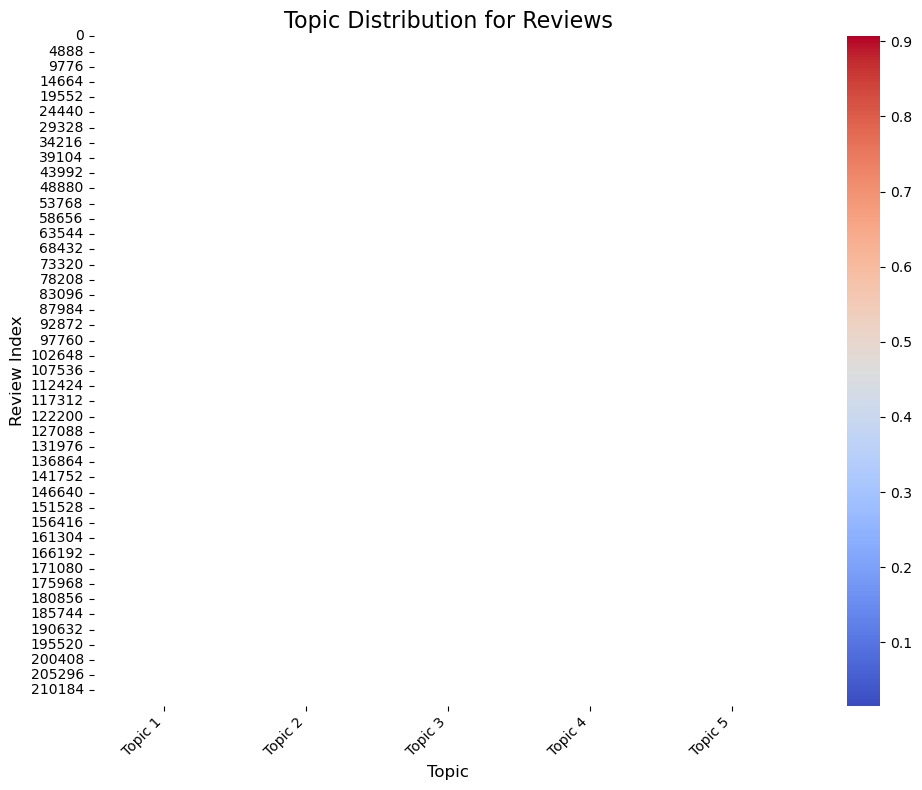

In [26]:
# Vectorizing the text using TF-IDF with min_df to exclude rare words
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=2000,  # Limit the number of features (terms) for efficiency
    min_df=5            # Exclude words that appear in fewer than 5 documents
)

X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

# Applying LDA with 5 topics, using n_jobs=-1 for parallelization and learning_method='online' for faster convergence
lda = LatentDirichletAllocation(
    n_components=5,       # Number of topics
    random_state=42,
    n_jobs=-1,            # Use all CPU cores
    max_iter=10,          # Fewer iterations for faster training
    learning_method='online',  # Faster learning method for large datasets
    batch_size=128,       # Batch size for online learning
    evaluate_every=-1,    # Avoid evaluation at each iteration to save time
    verbose=0             # Silence output to speed up execution
)

# Fit LDA to the entire TF-IDF matrix
lda_fit = lda.fit_transform(X_tfidf)

# Get the top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

top_words = get_top_words(lda, tfidf_vectorizer.get_feature_names_out(), n_top_words=10)

# Print the top words for each topic
for i, topic in enumerate(top_words):
    print(f"Topic {i + 1}: {topic}")

# Visualize the topic distribution (using a subset of reviews if necessary to avoid crowding)
topic_distribution = pd.DataFrame(lda_fit, columns=[f"Topic {i+1}" for i in range(5)])

# Set up the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size for better readability
sns.heatmap(topic_distribution, cmap="coolwarm", annot=False, cbar=True, linewidths=0.5)

# Customize the axes to improve readability
plt.title("Topic Distribution for Reviews", fontsize=16)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Review Index", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better spacing
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Ensure the labels fit inside the figure area

# Show the plot
plt.show()


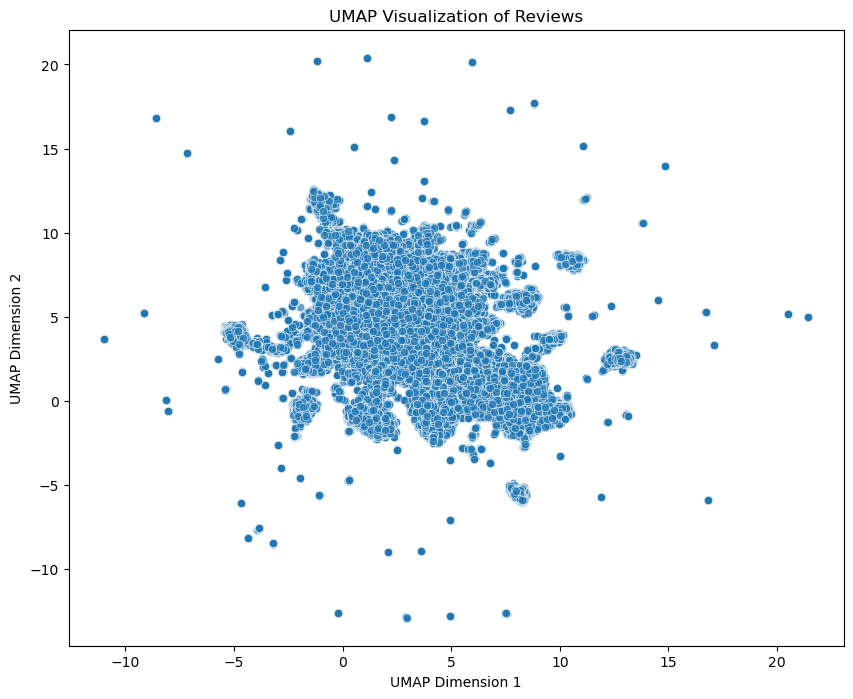

In [35]:
import umap
from sklearn.decomposition import PCA

# Vectorizing the text using TF-IDF 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(df1['lemmatized_review'].astype(str))

# Step 1: Use PCA to reduce dimensions before UMAP 
pca = PCA(n_components=100, random_state=42)  
X_pca = pca.fit_transform(X_tfidf.toarray())

# Step 2: Apply UMAP on the PCA-reduced data (UMAP is much faster than t-SNE)
# Remove random_state to enable parallel processing
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap_model.fit_transform(X_pca)

# Step 3: Create a DataFrame for visualization
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

# Step 4: Visualize the UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', data=umap_df, alpha=0.7, marker='o')
plt.title('UMAP Visualization of Reviews')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier 
# Train an SVM classifier (or SGDClassifier)
# Consider using SGDClassifier for faster training, especially with large datasets
svm_model = SGDClassifier(loss='hinge', random_state=42, tol=1e-3)  # Adjust hyperparameters as needed
svm_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64      9423
           1       0.89      0.91      0.90     33590

    accuracy                           0.85     43013
   macro avg       0.78      0.76      0.77     43013
weighted avg       0.84      0.85      0.85     43013



In [13]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier with optimized parameters
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9423
           1       0.78      1.00      0.88     33590

    accuracy                           0.78     43013
   macro avg       0.39      0.50      0.44     43013
weighted avg       0.61      0.78      0.68     43013



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.78      0.45      0.57      9423
           1       0.86      0.96      0.91     33590

    accuracy                           0.85     43013
   macro avg       0.82      0.71      0.74     43013
weighted avg       0.84      0.85      0.83     43013



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

# Assuming df1 and y are defined
# Text Preprocessing (Tokenization and Padding)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lower case
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Preprocess the text data
df1['lemmatized_review'] = df1['review'].apply(preprocess_text)

# Convert text data into sequences using CountVectorizer (you can use TfidfVectorizer as well)
vectorizer = CountVectorizer(max_features=500)
X = vectorizer.fit_transform(df1['lemmatized_review']).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Build the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)  # Fully connected layer (use the input as features)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM (batch_size, seq_len, input_dim)
        lstm_out, (ht, ct) = self.lstm(x)
        out = self.fc_out(ht[-1])
        out = self.sigmoid(out)
        return out

# Model parameters
input_dim = 5000  # Size of the vocabulary (num_words)
embedding_dim = 128
hidden_dim = 100
output_dim = 1  # Binary classification

# Initialize the model
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        preds = (outputs.squeeze() > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_preds += len(labels)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = (outputs.squeeze() > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_preds += len(labels)

test_accuracy = correct_preds / total_preds
print(f"Test Accuracy: {test_accuracy:.4f}")



/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


AttributeError: type object 'GuardSource' has no attribute 'LOCAL_NN_MODULE'

In [19]:

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize and encode the text data
inputs = tokenizer(df1['review'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Prepare dataset for Hugging Face Trainer
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.inputs.items()}, self.labels[idx]

# Split into train/test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df1['review'], y, test_size=0.2, random_state=42)

# Encode train and test data
train_encodings = tokenizer(train_texts.tolist(), padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(test_texts.tolist(), padding=True, truncation=True, return_tensors='pt')

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

# Train the model using Hugging Face Trainer API
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

ImportError: 
BertForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFBertForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [55]:
# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text) 
        text = re.sub(r'[^\w\s]', '', text) 
    return text

# Clean the reviews column
df2['cleaned_reviews'] = df2['reviews'].apply(clean_text)

# Check the cleaned column
print(df2[['cleaned_reviews']].head())


                                     cleaned_reviews
0  slowed the progression of left ventricular dys...
1  although this type of birth control has more c...
2  i was used to having cramps so badly that they...
3  the acid reflux went away for a few months aft...
4  i think that the lyrica was starting to help w...


In [56]:
# Ensure you have the stopwords downloaded
stop_words = set(stopwords.words('english'))

# Tokenization function
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        words = [word for word in words if word not in stop_words]
        return words
    return []

# Apply tokenization to the cleaned_reviews column
df2['tokens_reviews'] = df2['cleaned_reviews'].apply(tokenize_and_remove_stopwords)

# Check the tokenized column
print(df2[['reviews', 'cleaned_reviews', 'tokens_reviews']].head())


                                             reviews  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                     cleaned_reviews  \
0  slowed the progression of left ventricular dys...   
1  although this type of birth control has more c...   
2  i was used to having cramps so badly that they...   
3  the acid reflux went away for a few months aft...   
4  i think that the lyrica was starting to help w...   

                                      tokens_reviews  
0  [slowed, progression, left, ventricular, dysfu...  
1  [although, type, birth, control, cons, pros, h...  
2  [used, cramps, badly, would, leave, balled, be...  
3  [acid, reflux, went, away, months, days, drug,...  
4  [think, lyrica, starting, help, pain, sideeffe..

In [57]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatization function
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the tokens_reviews column
df2['lemmatized_reviews'] = df2['tokens_reviews'].apply(lemmatize_words)

# Check the lemmatized column
print(df2[['reviews', 'cleaned_reviews', 'tokens_reviews', 'lemmatized_reviews']].head())


                                             reviews  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   

                                     cleaned_reviews  \
0  slowed the progression of left ventricular dys...   
1  although this type of birth control has more c...   
2  i was used to having cramps so badly that they...   
3  the acid reflux went away for a few months aft...   
4  i think that the lyrica was starting to help w...   

                                      tokens_reviews  \
0  [slowed, progression, left, ventricular, dysfu...   
1  [although, type, birth, control, cons, pros, h...   
2  [used, cramps, badly, would, leave, balled, be...   
3  [acid, reflux, went, away, months, days, drug,...   
4  [think, lyrica, starting, help, pain, sidee

In [58]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment function
def analyze_sentiment(tokens):
    text = ' '.join(tokens)
    return sia.polarity_scores(text)

# Apply sentiment analysis to the lemmatized_reviews
df2['reviews_sentiment'] = df2['lemmatized_reviews'].apply(analyze_sentiment)
df2['sentiment_score'] = df2['reviews_sentiment'].apply(lambda x: x['compound'])

# Check sentiment analysis results
print(df2[['sentiment_score', 'reviews_sentiment']].head())


   sentiment_score                                  reviews_sentiment
0          -0.9758  {'neg': 0.46, 'neu': 0.54, 'pos': 0.0, 'compou...
1           0.6486  {'neg': 0.178, 'neu': 0.594, 'pos': 0.228, 'co...
2          -0.6121  {'neg': 0.252, 'neu': 0.59, 'pos': 0.158, 'com...
3          -0.7783  {'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'comp...
4          -0.4939  {'neg': 0.193, 'neu': 0.719, 'pos': 0.088, 'co...


/var/folders/62/mz1wg80n407bz3b_1h0t6szc0000gn/T/ipykernel_34635/4036211375.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Frequency', y='Word', data=word_df, palette=palette)


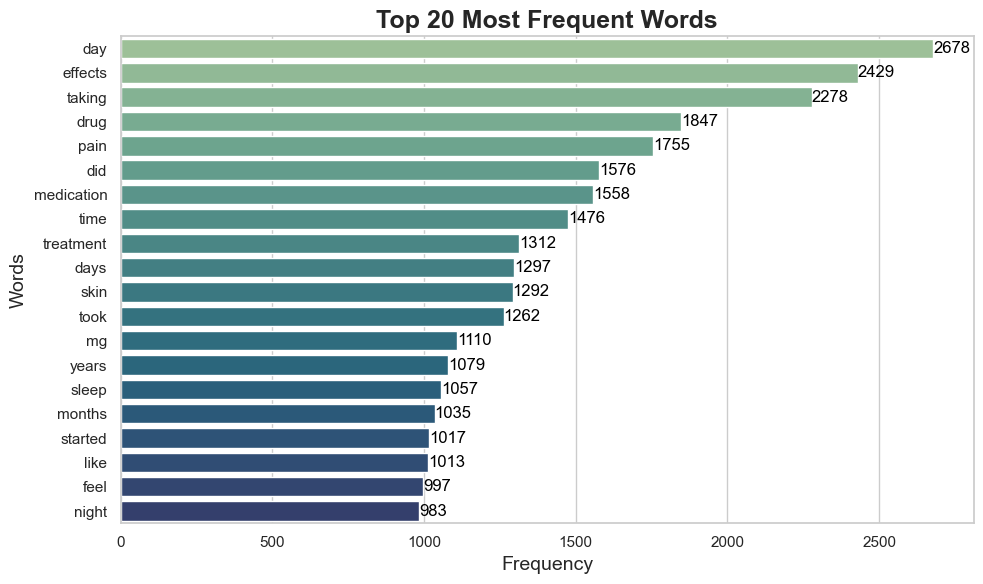

In [59]:
# Function to plot most frequent words
def plot_most_frequent_words(text_column, top_n=15):
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
    word_matrix = vectorizer.fit_transform(text_column)
    word_freq = np.asarray(word_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()

    word_freq_dict = dict(zip(words, word_freq))
    sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(sorted_words, columns=['Word', 'Frequency'])

    plt.figure(figsize=(10, 6))
    sns.set(style='whitegrid')  # Use a white grid style
    palette = sns.color_palette("crest", n_colors=top_n)  # Improved color palette

    # Create a horizontal bar plot
    bar_plot = sns.barplot(x='Frequency', y='Word', data=word_df, palette=palette)
    plt.title(f'Top {top_n} Most Frequent Words', fontsize=18, weight='bold')
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    
    # Add value annotations on the bars
    for index, value in enumerate(word_df['Frequency']):
        bar_plot.text(value, index, f'{value}', color='black', ha='left', va='center')

    plt.tight_layout()
    plt.show()

# Analyze the whole dataset using the 'reviews' column
if 'reviews' in df2.columns:
    plot_most_frequent_words(df2['reviews'].astype(str), top_n=20)


In [60]:
# Topic modeling on reviews
if 'reviews' in df2.columns:
    # Use the entire dataset instead of sampling
    text_column = df2['reviews'].astype(str)

    # Create the CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', max_features=500)
    X = vectorizer.fit_transform(text_column)

    # Apply LDA for topic modeling
    lda = LatentDirichletAllocation(n_components=3, random_state=42)
    lda.fit(X)

    # Function to display top words in each topic
    def print_lda_topics(lda, vectorizer, top_n=10):
        words = vectorizer.get_feature_names_out()
        for i, topic in enumerate(lda.components_):
            print(f"Topic {i + 1}:")
            print([words[i] for i in topic.argsort()[-top_n:]])

    # Display the topics
    print_lda_topics(lda, vectorizer)

Topic 1:
['severe', 'did', 'medication', 'took', 'drug', 'effects', 'taking', 'days', 'day', 'pain']
Topic 2:
['pressure', 'dry', 'face', 'day', 'use', 'effects', 'treatment', 'blood', 'acne', 'skin']
Topic 3:
['medication', 'feel', 'depression', 'time', 'drug', 'sleep', 'mg', 'effects', 'day', 'taking']
